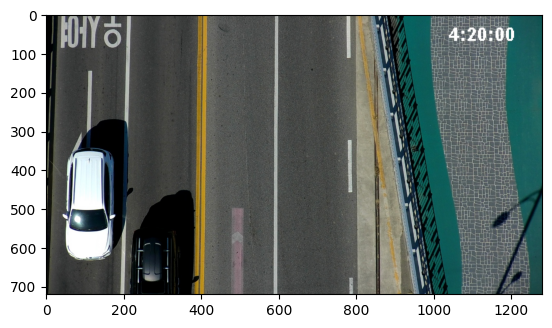

In [941]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings(action = "ignore")

img = cv2.imread("./sample/sample1/2022-10-20_134950.517.jpg") # , cv2.IMREAD_GRAYSCALE
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def show(img):
    cv2.imshow("image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def plt_show(img):
    convert = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(convert)
    plt.show()

plt_show(img)
# show(img)

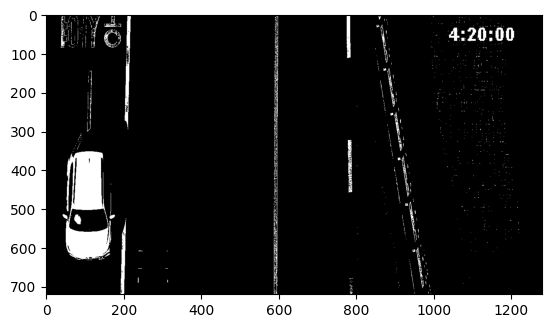

In [942]:
gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret2, thresh2 = cv2.threshold(gray2, 180, 255, cv2.THRESH_BINARY)

plt_show(thresh2)

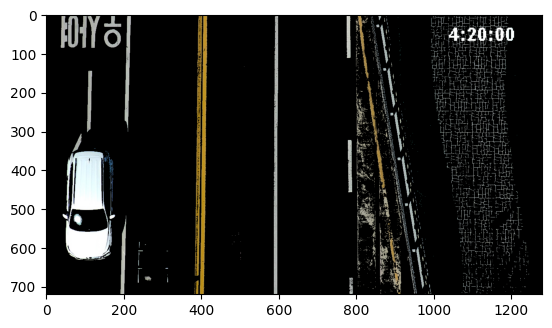

In [943]:
# BGR이미지를 HSL이미지로 변환 후 노락색과 흰색 부분만 검출

def color_filter(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    white_lower = np.array([0, 150, 0]) # 20, 150, 20
    white_upper = np.array([255, 255, 255])

    yellow_lower = np.array([0, 85, 81]) # 0, 85, 81
    yellow_upper = np.array([190, 255, 255]) # 190, 255, 255

    yellow_mask = cv2.inRange(hls, yellow_lower, yellow_upper)
    white_mask = cv2.inRange(hls, white_lower, white_upper)
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    
    return masked
w_f_r_img = color_filter(img)
plt_show(w_f_r_img)


In [944]:
# gray = cv2.GaussianBlur(gray, (5, 5), 5)
# gray = cv2.Canny(gray, 50, 300)
# gray = cv2.bilateralFilter(gray, -1, 50, 10)

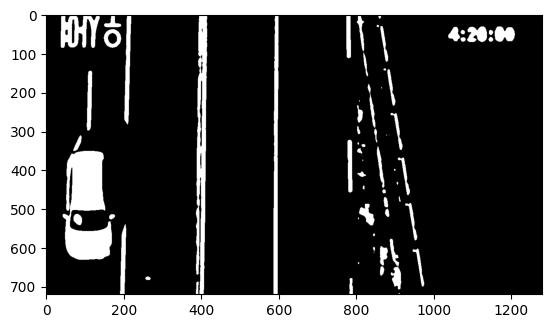

In [945]:
# 그레이 스케일로 변환 후 이진화

gray = cv2.cvtColor(w_f_r_img, cv2.COLOR_BGR2GRAY)
blured = cv2.GaussianBlur(gray, (0, 0), 3)
ret, thresh = cv2.threshold(blured, 0, 255, cv2.THRESH_OTSU)
# th3 = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
#                                      cv2.THRESH_BINARY, 9, 3)
plt_show(thresh)
# show(thresh)

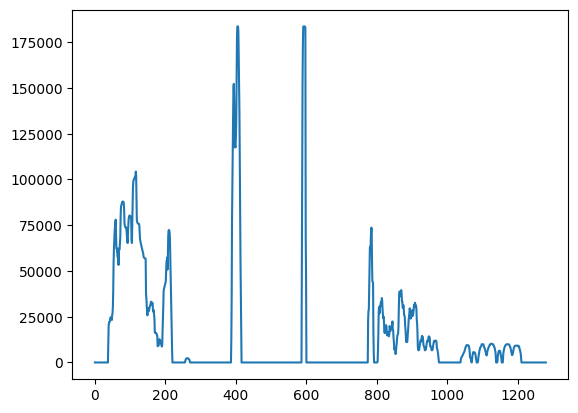

In [946]:
histo = np.sum(thresh[:, :], axis=0)
plt.plot(histo)

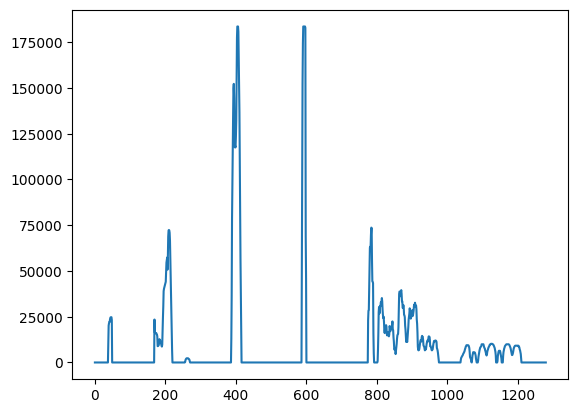

In [947]:
n = 60

histo = np.sum(thresh[:, :], axis=0)
for i in range(thresh.shape[1]):
    if (histo[i:i+n] > 25000).all():
        histo[i:i+n] = 0 
        
plt.plot(histo)

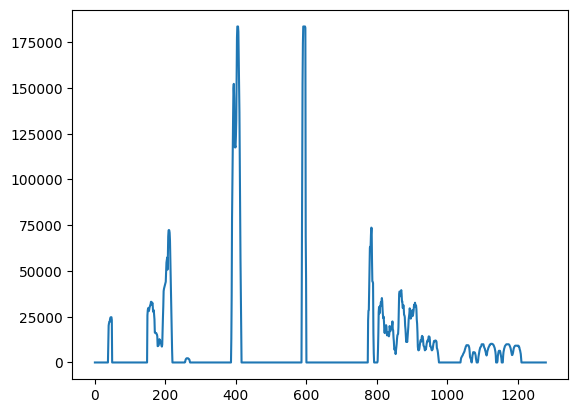

In [948]:
# 하나의 열의 모든 행의 값 계산

def plothistogram(image):
    n = 50
    threshold = 50000
    width = 20
    psms = 10
    cnt_left = 0
    cnt_right = 1
    lane_index_list = []

    histogram = np.sum(thresh[:, :], axis=0)
    for i in range(thresh.shape[1]):
        if (histogram[i:i+n] > 25000).all():
            histogram[i:i+n] = 0   
            
    midpoint = np.argmax(histogram)

    for left_point in range(midpoint, 0, -width):
        if (histogram[left_point-psms:left_point+psms] > threshold).any():
            lane_point = np.argmax(histogram[left_point-psms:left_point+psms]) + midpoint - cnt_left*width - psms
            lane_index_list.append(lane_point)
        cnt_left += 1
            
    for right_point in range(midpoint + width, image.shape[1], width):
        if (histogram[right_point-psms:right_point+psms] > threshold).any():
            lane_point = np.argmax(histogram[right_point-psms:right_point+psms]) + midpoint + cnt_right*width - psms
            lane_index_list.append(lane_point)
        cnt_right += 1
        
    lane_index_list.sort()
        
    return lane_index_list, histogram

lane_index_list, histogram = plothistogram(thresh)
plt.plot(histogram)

In [949]:
lane_index_list

[210, 214, 393, 404, 591, 594, 784]

In [950]:
# # 하나의 열의 모든 행의 값 계산

# def plothistogram(image):
#     histogram = np.sum(image[:, :], axis=0)
#     midpoint = np.argmax(histogram)

#     cnt = 1
#     lane_index_list = []

#     for left_point, right_point in zip(range(midpoint + 200, image.shape[1], 200), range(midpoint, 0, -200)):
#         if (histogram[left_point-50:left_point+50] > 65000).any():
#             lane_point = np.argmax(histogram[left_point-50:left_point+50]) + midpoint + cnt*200 - 50
#             lane_index_list.append(lane_point)
#         if (histogram[right_point-50:right_point+50] > 65000).any():
#             lane_point = np.argmax(histogram[right_point-50:right_point+50]) + midpoint - cnt*200 + 150
#             lane_index_list.append(lane_point)
#         cnt += 1
        
#     lane_index_list.sort()
        
#     return lane_index_list, histogram

# lane_index_list, histogram = plothistogram(thresh)
# plt.plot(histogram)

826
824
299
0
0
0
705
808
797
900
699
824
299
0
0
0
705
808
797
900
1078
1291
1339
1291
1531
1464
1271
1411
1434
1558
1078
1291
1339
1291
1531
1464
1271
1411
1434
1558
792
792
792
725
686
681
735
764
734
684
792
792
792
725
686
681
735
764
734
684
323
3
4
284
795
437
8
0
465
798


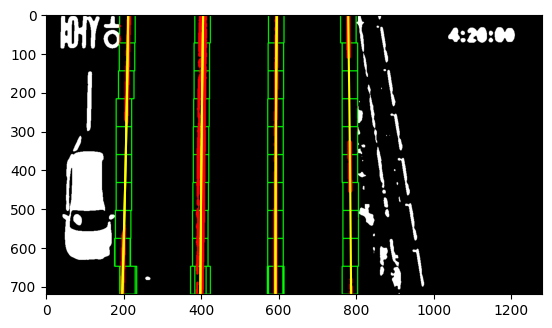

In [951]:
# Window Sliding Search

def slide_window_search(binary_warped, lane_index_list):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    nwindows = 10
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero() # 선이 있는 부분의 인덱스만 저장 
    nonzero_y = np.array(nonzero[0])  # 선이 있는 부분 y의 인덱스 값
    nonzero_x = np.array(nonzero[1])  # 선이 있는 부분 x의 인덱스 값 
    margin = 20
    minpix = 50
    fitx_list = []
    color = [0, 255, 0]
    thickness = 2
    
    for lane in lane_index_list:
        lane_list = []
        for w in range(nwindows):
            win_y_low = binary_warped.shape[0] - (w + 1) * window_height  # window 윗부분
            win_y_high = binary_warped.shape[0] - w * window_height  # window 아랫 부분
            win_x_low = lane - margin
            win_x_high = lane + margin
            
            cv2.rectangle(out_img, (win_x_low, win_y_low), (win_x_high, win_y_high), color, thickness)
            good_left = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_x_low) & (nonzero_x < win_x_high)).nonzero()[0]

            lane_list.append(good_left)
            print(len(good_left))
            if len(good_left) > minpix:
                lane = np.int(np.mean(nonzero_x[good_left]))   

        lane_list = np.concatenate(lane_list)
        x = nonzero_x[lane_list]
        y = nonzero_y[lane_list]

        fit = np.polyfit(y, x, 2)

        ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
        fitx = fit[0] * ploty ** 2 + fit[1] * ploty + fit[2]

        out_img[nonzero_y[lane_list], nonzero_x[lane_list]] = [255, 0, 0]

        fitx_list.append(fitx)
        
    plt.imshow(out_img)
    for p in range(len(fitx_list)):
        plt.plot(fitx_list[p], ploty, color = "yellow")
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)
    plt.show()
    
    return fitx_list, ploty

fitx_list, ploty = slide_window_search(thresh, lane_index_list)

In [952]:
# 왼쪽 오른쪽 차선 경계 추출

def minmax_mean(fitx_list):
    each_mean = []

    for i in range(len(fitx_list)):
        fitx_list[i] = np.trunc(fitx_list[i])
        mean = np.mean(fitx_list[i])
        each_mean.append(mean)
        
    left_fitx = fitx_list[each_mean.index(np.min(each_mean))]
    right_fitx = fitx_list[each_mean.index(np.max(each_mean))]
    
    return left_fitx, right_fitx

left_fitx, right_fitx = minmax_mean(fitx_list)

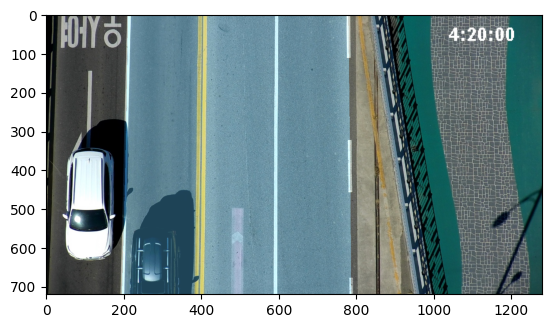

In [953]:
# 도로 영역 표현

def draw_lane_lines(original_image, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros([img.shape[0], img.shape[1]])
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    mean_x = np.mean((left_fitx, right_fitx), axis=0)
    pts_mean = np.array([np.flipud(np.transpose(np.vstack([mean_x, ploty])))])

    cv2.fillPoly(color_warp, np.int_([pts]), (216, 168, 74))
    cv2.fillPoly(color_warp, np.int_([pts_mean]), (216, 168, 74))

    result = cv2.addWeighted(original_image, 1, color_warp, 0.4, 0, dtype = cv2.CV_8U)

    return pts_mean, result, color_warp

meanPts, result, color_warp = draw_lane_lines(img, left_fitx, right_fitx, ploty)

plt_show(result)
# show(result)

In [954]:
dst = img.copy()

In [955]:
# 도로 외 영역, 차선 제거

def trim_lane(image):
    image[color_warp == 0] = image[color_warp == 0] * 0

    for k in range(len(fitx_list)):
        for i, j in zip(fitx_list[k], ploty):
            cv2.line(image, (int(i), int(j)), (int(i), int(j)), (0), 10)
    
    return image

result2 = trim_lane(dst)

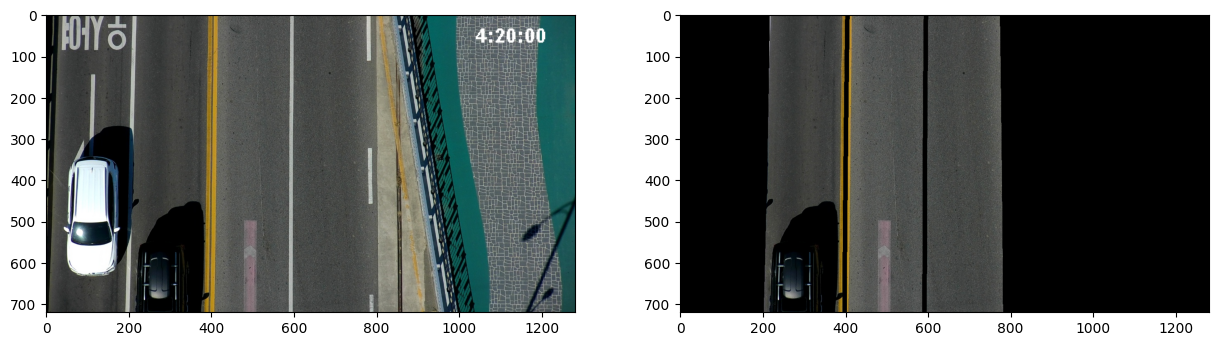

In [956]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result2_rgb = cv2.cvtColor(result2, cv2.COLOR_BGR2RGB)
    
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.subplot(1,2,2)
plt.imshow(result2_rgb)
plt.show()

##### BackUp

In [ ]:
# 하나의 열의 모든 행의 값 계산

def plothistogram(image):
    histogram = np.sum(image[:, :], axis=0)
    midpoint = np.argmax(histogram)

    if (histogram[midpoint-250:midpoint-150] > 75000).any():
        leftbase_1 = np.argmax(histogram[midpoint-250:midpoint-150]) + midpoint - 250
    
    if (histogram[leftbase_1-250:leftbase_1-150] > 75000).any():
        leftbase_2 = np.argmax(histogram[leftbase_1-250:leftbase_1-150]) + midpoint - 250
    
    if (histogram[midpoint+150:midpoint+250] > 75000).any():
        rightbase_1 = np.argmax(histogram[midpoint+150:midpoint+250]) + midpoint + 150
        
    if (histogram[rightbase_1+150:rightbase_1+250] > 75000).any():
        rightbase_2 = np.argmax(histogram[rightbase_1+150:rightbase_1+250]) + rightbase_1 + 150
        
    return leftbase_1, leftbase_2, midpoint, rightbase_1, rightbase_2, histogram

leftbase_1, leftbase_2, midpoint, rightbase_1, rightbase_2, histogram = plothistogram(thresh)
plt.plot(histogram)

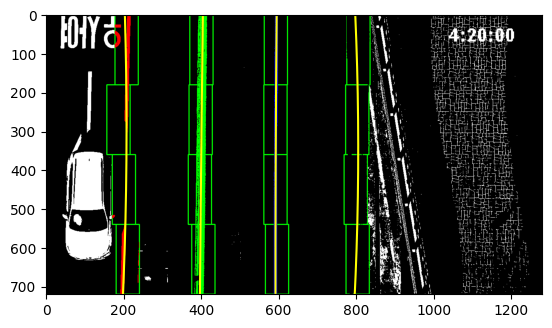

In [17]:
# Window Sliding Search

import warnings
warnings.filterwarnings(action = "ignore")

def slide_window_search(binary_warped, left_current, right_current, mid_current, right2_current):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    nwindows = 4
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()  # 선이 있는 부분의 인덱스만 저장 
    nonzero_y = np.array(nonzero[0])  # 선이 있는 부분 y의 인덱스 값
    nonzero_x = np.array(nonzero[1])  # 선이 있는 부분 x의 인덱스 값 
    margin = 30
    minpix = 30
    left_lane = []
    right_lane = []
    mid_lane = []
    right2_lane = []
    color = [0, 255, 0]
    thickness = 2

    for w in range(nwindows):
        win_y_low = binary_warped.shape[0] - (w + 1) * window_height  # window 윗부분
        win_y_high = binary_warped.shape[0] - w * window_height  # window 아랫 부분
        win_xleft_low = left_current - margin  # 왼쪽 window 왼쪽 위
        win_xleft_high = left_current + margin  # 왼쪽 window 오른쪽 아래
        win_xright_low = right_current - margin  # 오른쪽 window 왼쪽 위 
        win_xright_high = right_current + margin  # 오른쪽 window 오른쪽 아래
        
        win_xmid_low = mid_current - margin
        win_xmid_high = mid_current + margin
        win_xright2_low = right2_current - margin
        win_xright2_high = right2_current + margin

        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), color, thickness)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), color, thickness)
        
        cv2.rectangle(out_img, (win_xmid_low, win_y_low), (win_xmid_high, win_y_high), color, thickness)
        cv2.rectangle(out_img, (win_xright2_low, win_y_low), (win_xright2_high, win_y_high), color, thickness)
        
        good_left = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]
        
        good_mid = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xmid_low) & (nonzero_x < win_xmid_high)).nonzero()[0]
        good_right2 = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright2_low) & (nonzero_x < win_xright2_high)).nonzero()[0]
        
        left_lane.append(good_left)
        right_lane.append(good_right)
        
        mid_lane.append(good_mid)
        right2_lane.append(good_right2)
        # cv2.imshow("oo", out_img)

        if len(good_left) > minpix:
            left_current = np.int(np.mean(nonzero_x[good_left]))
        if len(good_right) > minpix:
            right_current = np.int(np.mean(nonzero_x[good_right]))
            
        if len(good_mid) > minpix:
            mid_current = np.int(np.mean(nonzero_x[good_mid]))
        if len(good_right2) > minpix:
            right2_current = np.int(np.mean(nonzero_x[good_right2]))
    

    left_lane = np.concatenate(left_lane)  # np.concatenate() -> array를 1차원으로 합침
    right_lane = np.concatenate(right_lane)
    
    mid_lane = np.concatenate(mid_lane)
    right2_lane = np.concatenate(right2_lane)

    leftx = nonzero_x[left_lane]
    lefty = nonzero_y[left_lane]
    rightx = nonzero_x[right_lane]
    righty = nonzero_y[right_lane]
    
    midx = nonzero_x[mid_lane]
    midy = nonzero_y[mid_lane]
    right2x = nonzero_x[right2_lane]
    right2y = nonzero_y[right2_lane]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    mid_fit = np.polyfit(midy, midx, 2)
    right2_fit = np.polyfit(right2y, right2x, 2)

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    mid_fitx = mid_fit[0] * ploty ** 2 + mid_fit[1] * ploty + mid_fit[2]
    right2_fitx = right2_fit[0] * ploty ** 2 + right2_fit[1] * ploty + right2_fit[2]

    ltx = np.trunc(left_fitx)  # np.trunc() -> 소수점 부분을 버림
    rtx = np.trunc(right_fitx)
    
    mtx = np.trunc(mid_fitx)
    r2tx = np.trunc(right2_fitx)

    out_img[nonzero_y[left_lane], nonzero_x[left_lane]] = [255, 0, 0]
    out_img[nonzero_y[right_lane], nonzero_x[right_lane]] = [0, 0, 255]
    
    out_img[nonzero_y[mid_lane], nonzero_x[mid_lane]] = [0, 255, 0]
    out_img[nonzero_y[right2_lane], nonzero_x[right2_lane]] = [0, 0, 0]

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color = 'yellow')
    plt.plot(right_fitx, ploty, color = 'yellow')
    plt.plot(mid_fitx, ploty, color = 'yellow')
    plt.plot(right2_fitx, ploty, color = 'yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

    ret = {'left_fitx' : ltx, 'right_fitx': rtx, 'mid_fitx': mtx, 'right2_fitx': r2tx, 'ploty': ploty}

    return ret

draw_info = slide_window_search(thresh, leftbase_1, rightbase_1, midpoint, rightbase_2)

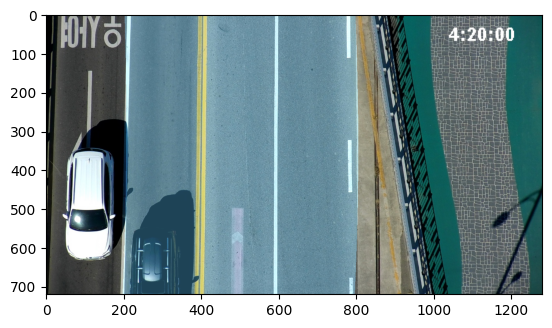

In [18]:
# 도로 영역 표현

def draw_lane_lines(original_image, draw_info):
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right2_fitx']
    ploty = draw_info['ploty']

    warp_zero = np.zeros([720, 1280])
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    mean_x = np.mean((left_fitx, right_fitx), axis=0)
    pts_mean = np.array([np.flipud(np.transpose(np.vstack([mean_x, ploty])))])

    cv2.fillPoly(color_warp, np.int_([pts]), (216, 168, 74))
    cv2.fillPoly(color_warp, np.int_([pts_mean]), (216, 168, 74))

    result = cv2.addWeighted(img, 1, color_warp, 0.4, 0, dtype = cv2.CV_8U)

    return pts_mean, result

meanPts, result = draw_lane_lines(img, draw_info)

plt_show(result)
show(result)

##### BackUp2

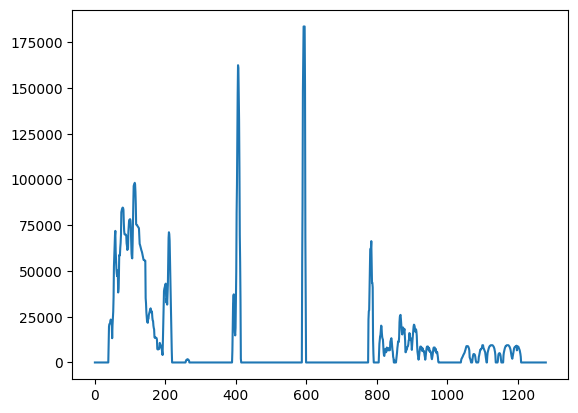

In [21]:
# 하나의 열의 모든 행의 값 계산

def plothistogram(image):
    histogram = np.sum(image[:, :], axis=0) # image[image.shape[0]//2:, :] image[:, :]
    midpoint = np.int(histogram.shape[0]/2)
    leftbase = np.argmax(histogram[:midpoint])
    rightbase = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftbase, rightbase, histogram

leftbase, rightbase, histogram = plothistogram(thresh)
plt.plot(histogram)

In [22]:
print("mean: ", np.mean(histogram))
print("max: ", np.max(histogram))
print("median: ", np.median(histogram))

mean:  11402.28515625
max:  183600
median:  0.0


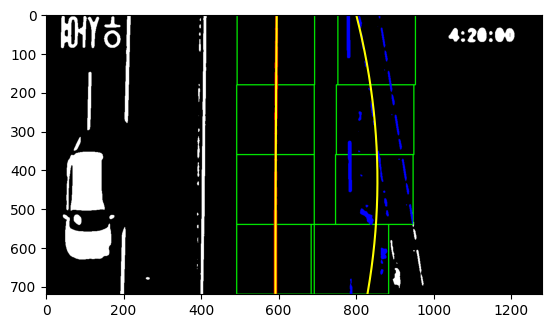

In [26]:
import warnings
warnings.filterwarnings(action = "ignore")

def slide_window_search(binary_warped, left_current, right_current):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    nwindows = 4
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()  # 선이 있는 부분의 인덱스만 저장 
    nonzero_y = np.array(nonzero[0])  # 선이 있는 부분 y의 인덱스 값
    nonzero_x = np.array(nonzero[1])  # 선이 있는 부분 x의 인덱스 값 
    margin = 100
    minpix = 50
    left_lane = []
    right_lane = []
    color = [0, 255, 0]
    thickness = 2

    for w in range(nwindows):
        win_y_low = binary_warped.shape[0] - (w + 1) * window_height  # window 윗부분
        win_y_high = binary_warped.shape[0] - w * window_height  # window 아랫 부분
        win_xleft_low = left_current - margin  # 왼쪽 window 왼쪽 위
        win_xleft_high = left_current + margin  # 왼쪽 window 오른쪽 아래
        win_xright_low = right_current - margin  # 오른쪽 window 왼쪽 위 
        win_xright_high = right_current + margin  # 오른쪽 window 오른쪽 아래

        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), color, thickness)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), color, thickness)
        good_left = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]
        left_lane.append(good_left)
        right_lane.append(good_right)
        # cv2.imshow("oo", out_img)

        if len(good_left) > minpix:
            left_current = np.int(np.mean(nonzero_x[good_left]))
        if len(good_right) > minpix:
            right_current = np.int(np.mean(nonzero_x[good_right]))

    left_lane = np.concatenate(left_lane)  # np.concatenate() -> array를 1차원으로 합침
    right_lane = np.concatenate(right_lane)

    leftx = nonzero_x[left_lane]
    lefty = nonzero_y[left_lane]
    rightx = nonzero_x[right_lane]
    righty = nonzero_y[right_lane]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    ltx = np.trunc(left_fitx)  # np.trunc() -> 소수점 부분을 버림
    rtx = np.trunc(right_fitx)

    out_img[nonzero_y[left_lane], nonzero_x[left_lane]] = [255, 0, 0]
    out_img[nonzero_y[right_lane], nonzero_x[right_lane]] = [0, 0, 255]

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color = 'yellow')
    plt.plot(right_fitx, ploty, color = 'yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

    ret = {'left_fitx' : ltx, 'right_fitx': rtx, 'ploty': ploty}

    return ret

draw_info = slide_window_search(thresh, leftbase, rightbase)

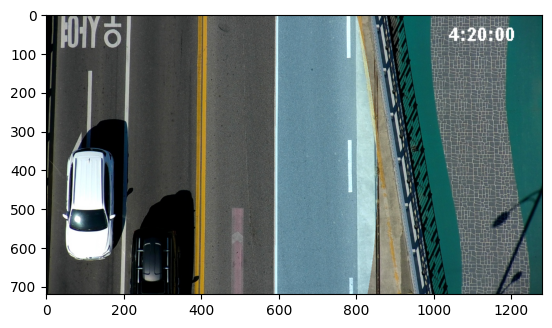

In [27]:
# 도로 영역 표현

def draw_lane_lines(original_image, draw_info):
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']

    warp_zero = np.zeros([720, 1280])
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    mean_x = np.mean((left_fitx, right_fitx), axis=0)
    pts_mean = np.array([np.flipud(np.transpose(np.vstack([mean_x, ploty])))])

    cv2.fillPoly(color_warp, np.int_([pts]), (216, 168, 74))
    cv2.fillPoly(color_warp, np.int_([pts_mean]), (216, 168, 74))

    result = cv2.addWeighted(img, 1, color_warp, 0.4, 0, dtype = cv2.CV_8U)

    return pts_mean, result

meanPts, result = draw_lane_lines(img, draw_info)

plt_show(result)
show(result)